## Climate Analysis and Exploration

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.ticker as ticker

import pymysql
pymysql.install_as_MySQLdb()

import seaborn as sns
import matplotlib.dates as mdates

from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [7]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [8]:
inspector = inspect(engine)

In [9]:
tables = {} 
for table in inspector.get_table_names():
    print(f'Table name is "{table}" and has these columns: ')
    columns = inspector.get_columns(table)
    names = []
    for c in columns:
        names.append(c['name'])
        print(c['name'], c['type'])
    print()
    tables[table] = names

Table name is "measurement" and has these columns: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table name is "station" and has these columns: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

In [14]:
# find the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# convert string to df format
date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
# subtract 365 days to get to one year time frame
year_ago = date - dt.timedelta(days=365)

In [15]:
# pull data from Measurement filtering on one year time frame
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

In [16]:
#  Create dataframe of this data
df = pd.DataFrame(last_year_prcp, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


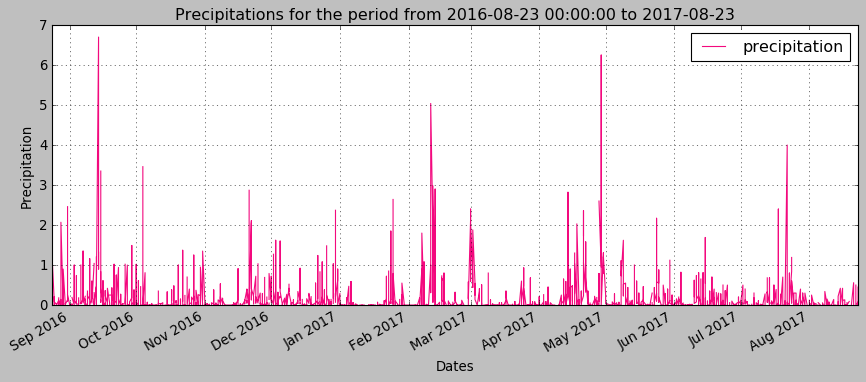

In [17]:
# Plot precipitation graph and save to file 
plt.style.use('classic')
ax = df.plot(title=f'Precipitations for the period from {year_ago} to {last_date[0][0:10]}', color='#F3097E',\
             grid=True, figsize=(13,5))
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation')
plt.savefig("Image/Precipitation.png")

In [18]:
#create a plot

# thing = date_precip_df.plot(title='Precipitation Totals for Hawaii (08-24-16 to 08-24-17)')

# plt.xticks(rotation= '45')
# thing.set_ylabel("Precipitation (in)")
# plt.show()

# fig = thing.get_figure()
# fig.savefig('asdf.png')

In [19]:
# Total rain aount
total_rain = df["precipitation"].sum()
total_rain

355.57000000000005

In [20]:
# summary statistics for the precipitation data
rain_stats = df.describe()
rain_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Set stations_first as a variable.
station_first = session.query(Station).first()
station_first

In [22]:
#Show the first row of the stations table.
station_first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xbbb0240>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

### Station Analysis

In [23]:
# How many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations

9

In [24]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
        
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best_station = active_station[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [26]:
# Most active station
most_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
most_active

('USC00519281')

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs).filter(Measurement.date > year_ago).\
                    filter(Measurement.station == most_active[0]).all()

In [28]:
df = pd.DataFrame(last_year_temp, columns=['Temperature'])

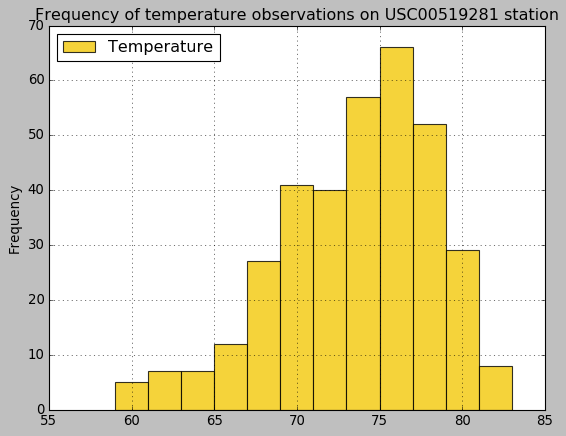

In [29]:
# plot the results as a histogram
df.plot.hist(by='Temperature', bins=12, color='#F3C809',\
             title=f'Frequency of temperature observations on {most_active[0]} station', alpha=0.8, grid=True)
plt.savefig("Image/Temperature.png")

### Temperature Analysis Optional

In [30]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return c_results
calc_temps('2017-01-01', '2017-12-31')

[(58.0, 74.14387974230493, 87.0)]

In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-07-02', '2017-07-08')
trip_results

[(71.0, 78.11904761904762, 87.0)]

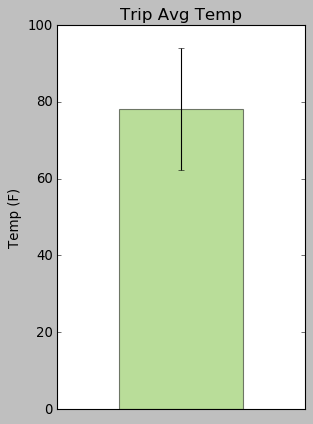

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(4,6), alpha=0.5, color='#75BD35', grid=True)
plt.title("Trip Avg Temp", fontsize=15)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Image/TripTemperature.png")
plt.show()

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, func.sum(Measurement.prcp)).filter((Measurement.date > year_ago)).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 147.11000000000004),
 ('USC00519281', 68.24000000000002),
 ('USC00513117', 48.36000000000003),
 ('USC00519523', 37.99),
 ('USC00514830', 33.19),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]

### Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(day):
    '''Calculates minimun, average and maximum temperature for a particular day taking into account all years.
    day - a string in format '%m-%d' '''
    day_dt = dt.datetime.strptime(day, '%m-%d')
    tempts = session.query((func.min(Measurement.tobs)), (func.avg(Measurement.tobs)), (func.max(Measurement.tobs))).\
    filter(func.strftime('%m', Measurement.date) == day_dt.strftime('%m')).\
    filter(func.strftime('%d', Measurement.date) == day_dt.strftime('%d')).\
    all()
    res = [t for t in tempts[0]]
    return res
daily_normals("01-31")

[60.0, 68.47368421052632, 74.0]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = "2017-03-25"
end_date = "2017-04-07"
vacation_days_short = []
vacation_days = [dt.datetime.strptime(d[0], '%Y-%m-%d') for d in session.query(Measurement.date).\
          filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()]
for d in vacation_days:
    vacation_days_short.append(f'{d.month}-{d.day}')
vacation_days

[datetime.datetime(2017, 3, 25, 0, 0),
 datetime.datetime(2017, 3, 26, 0, 0),
 datetime.datetime(2017, 3, 27, 0, 0),
 datetime.datetime(2017, 3, 28, 0, 0),
 datetime.datetime(2017, 3, 29, 0, 0),
 datetime.datetime(2017, 3, 30, 0, 0),
 datetime.datetime(2017, 3, 31, 0, 0),
 datetime.datetime(2017, 4, 1, 0, 0),
 datetime.datetime(2017, 4, 2, 0, 0),
 datetime.datetime(2017, 4, 3, 0, 0),
 datetime.datetime(2017, 4, 4, 0, 0),
 datetime.datetime(2017, 4, 5, 0, 0),
 datetime.datetime(2017, 4, 6, 0, 0),
 datetime.datetime(2017, 4, 7, 0, 0)]

In [36]:
vacation_temps = {}
for x in range(len(vacation_days_short)):
    vacation_temps[vacation_days[x]] = daily_normals(vacation_days_short[x])
    x += 1
vacation_temps

{datetime.datetime(2017, 3, 25, 0, 0): [63.0, 71.5, 78.0],
 datetime.datetime(2017, 3, 26, 0, 0): [64.0, 71.38, 80.0],
 datetime.datetime(2017, 3, 27, 0, 0): [63.0, 71.53846153846153, 80.0],
 datetime.datetime(2017, 3, 28, 0, 0): [59.0, 71.51785714285714, 82.0],
 datetime.datetime(2017, 3, 29, 0, 0): [58.0, 71.35714285714286, 77.0],
 datetime.datetime(2017, 3, 30, 0, 0): [62.0, 72.17543859649123, 79.0],
 datetime.datetime(2017, 3, 31, 0, 0): [61.0, 71.875, 79.0],
 datetime.datetime(2017, 4, 1, 0, 0): [60.0, 71.87931034482759, 80.0],
 datetime.datetime(2017, 4, 2, 0, 0): [53.0, 71.82142857142857, 79.0],
 datetime.datetime(2017, 4, 3, 0, 0): [55.0, 72.2280701754386, 78.0],
 datetime.datetime(2017, 4, 4, 0, 0): [58.0, 72.01639344262296, 78.0],
 datetime.datetime(2017, 4, 5, 0, 0): [61.0, 72.28813559322033, 80.0],
 datetime.datetime(2017, 4, 6, 0, 0): [67.0, 71.57142857142857, 77.0],
 datetime.datetime(2017, 4, 7, 0, 0): [63.0, 71.10526315789474, 78.0]}

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfdn = pd.DataFrame(vacation_temps).transpose()
dfdn.columns=['tmin', 'tavg', 'tmax']
dfdn

,tmin,tavg,tmax
2017-03-25,63.0,71.500000,78.0
2017-03-26,64.0,71.380000,80.0
2017-03-27,63.0,71.538462,80.0
2017-03-28,59.0,71.517857,82.0
2017-03-29,58.0,71.357143,77.0
2017-03-30,62.0,72.175439,79.0
2017-03-31,61.0,71.875000,79.0
2017-04-01,60.0,71.879310,80.0
2017-04-02,53.0,71.821429,79.0
2017-04-03,55.0,72.228070,78.0


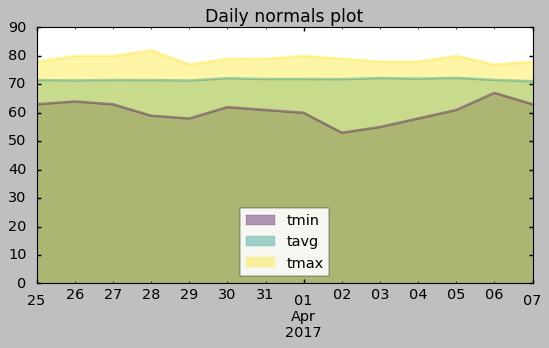

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
plt.style.use('seaborn-talk')
ax = dfdn.plot.area(stacked=False, figsize=(8,4), title='Daily normals plot', alpha=0.4,\
                    colormap='viridis')
ax.legend(loc=8, frameon=True, framealpha=0.9, edgecolor='black')
plt.savefig("Image/DailyNormal.png")